Rename all _nltk with _spacy to get the results for Spacy based preprocessed words

In [1]:
import pandas as pd
import numpy as np
import spacy

In [2]:
master_df = pd.read_csv('data/features_nltk.csv')
df = master_df[['headline', 'headline_cleaned', 'tokenized_text_nltk', 'lemmatized_text_nltk', 'is_sarcastic']].copy()
df.head()

,headline,headline_cleaned,tokenized_text_nltk,lemmatized_text_nltk,is_sarcastic
0,former versace store clerk sues over secret 'b...,former versace store clerk sues over secret bl...,"['former', 'versace', 'store', 'clerk', 'sues'...","['former', 'versace', 'store', 'clerk', 'sue',...",0
1,the 'roseanne' revival catches up to our thorn...,the roseanne revival catches up to our thorny ...,"['the', 'roseanne', 'revival', 'catches', 'up'...","['roseanne', 'revival', 'catch', 'thorny', 'po...",0
2,mom starting to fear son's web series closest ...,mom starting to fear sons web series closest t...,"['mom', 'starting', 'to', 'fear', 'sons', 'web...","['mom', 'starting', 'fear', 'son', 'web', 'ser...",1
3,"boehner just wants wife to listen, not come up...",boehner just wants wife to listen not come up ...,"['boehner', 'just', 'wants', 'wife', 'to', 'li...","['boehner', 'just', 'want', 'wife', 'listen', ...",1
4,j.k. rowling wishes snape happy birthday in th...,jk rowling wishes snape happy birthday in the ...,"['jk', 'rowling', 'wishes', 'snape', 'happy', ...","['jk', 'rowling', 'wish', 'snape', 'happy', 'b...",0


## Word2Vec

In [3]:
from gensim.models import Word2Vec

In [4]:
df['tokenized_text_nltk'] = df['tokenized_text_nltk'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').replace(",",''))
df['tokenized_text_nltk'] = df['tokenized_text_nltk'].apply(lambda x: x.split())
df['lemmatized_text_nltk'] = df['lemmatized_text_nltk'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').replace(",",''))
df['lemmatized_text_nltk'] = df['lemmatized_text_nltk'].apply(lambda x: x.split())

In [5]:
tokenized_sentences = df['tokenized_text_nltk'].tolist()
lemmatized_sentences = df['lemmatized_text_nltk'].tolist()

print(tokenized_sentences[0])


# Train Word2Vec models
w2v_tokenized = Word2Vec(tokenized_sentences, min_count=1, vector_size=100)
w2v_lemmatized = Word2Vec(lemmatized_sentences, min_count=1, vector_size=100)

['former', 'versace', 'store', 'clerk', 'sues', 'over', 'secret', 'black', 'code', 'for', 'minority', 'shoppers']


In [6]:
print(type(tokenized_sentences[0]))

<class 'list'>


In [7]:
# Function to get word embeddings for a sentence
def get_word2vec_embeddings(model, sentence):
    embeddings = []
    for word in sentence.split():
        try:
            embeddings.append(model.wv[word])
        except KeyError:
            embeddings.append([0]*100)  # Default vector if word not found
    return embeddings


In [8]:
# Get word embeddings for tokenized and lemmatized sentences (for each word in the sentence)
df['tokenized_word2vec'] = df['tokenized_text_nltk'].apply(lambda x: [get_word2vec_embeddings(w2v_tokenized, y) for y in x])
df['lemmatized_word2vec'] = df['lemmatized_text_nltk'].apply(lambda x: [get_word2vec_embeddings(w2v_lemmatized, y) for y in x])

In [9]:
df.head()

,headline,headline_cleaned,tokenized_text_nltk,lemmatized_text_nltk,is_sarcastic,tokenized_word2vec,lemmatized_word2vec
0,former versace store clerk sues over secret 'b...,former versace store clerk sues over secret bl...,"[former, versace, store, clerk, sues, over, se...","[former, versace, store, clerk, sue, secret, b...",0,"[[[-0.35040185, 0.48717874, 0.16970965, 0.2318...","[[[-0.33105177, 0.4596604, 0.19531539, 0.05192..."
1,the 'roseanne' revival catches up to our thorn...,the roseanne revival catches up to our thorny ...,"[the, roseanne, revival, catches, up, to, our,...","[roseanne, revival, catch, thorny, political, ...",0,"[[[-0.3027041, 0.60536647, 0.34633216, 0.22753...","[[[-0.023544664, 0.014043561, 0.005462277, 0.0..."
2,mom starting to fear son's web series closest ...,mom starting to fear sons web series closest t...,"[mom, starting, to, fear, sons, web, series, c...","[mom, starting, fear, son, web, series, closes...",1,"[[[-0.35815242, 0.47634047, 0.16607647, 0.2416...","[[[-0.48585722, 0.6641556, 0.2730123, 0.141048..."
3,"boehner just wants wife to listen, not come up...",boehner just wants wife to listen not come up ...,"[boehner, just, wants, wife, to, listen, not, ...","[boehner, just, want, wife, listen, not, come,...",1,"[[[-0.08780119, 0.1179156, 0.051013503, 0.0472...","[[[-0.0824285, 0.100141816, 0.040832598, 0.016..."
4,j.k. rowling wishes snape happy birthday in th...,jk rowling wishes snape happy birthday in the ...,"[jk, rowling, wishes, snape, happy, birthday, ...","[jk, rowling, wish, snape, happy, birthday, mo...",0,"[[[-0.02832416, 0.03161917, 0.01945503, 0.0242...","[[[-0.023884334, 0.03377983, 0.013643504, 0.00..."


In [16]:
def get_sentence_embedding(df, col='word2vec'):
    tok = df[f'tokenized_{col}']
    if len(tok.shape) == 3:
        sent = tok.apply(lambda x: np.asarray(x).squeeze().mean(axis=0))
    else:
        sent = tok.apply(lambda x: np.asarray(x).mean(axis=0))
    return sent

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
sent_w2v = get_sentence_embedding(df)

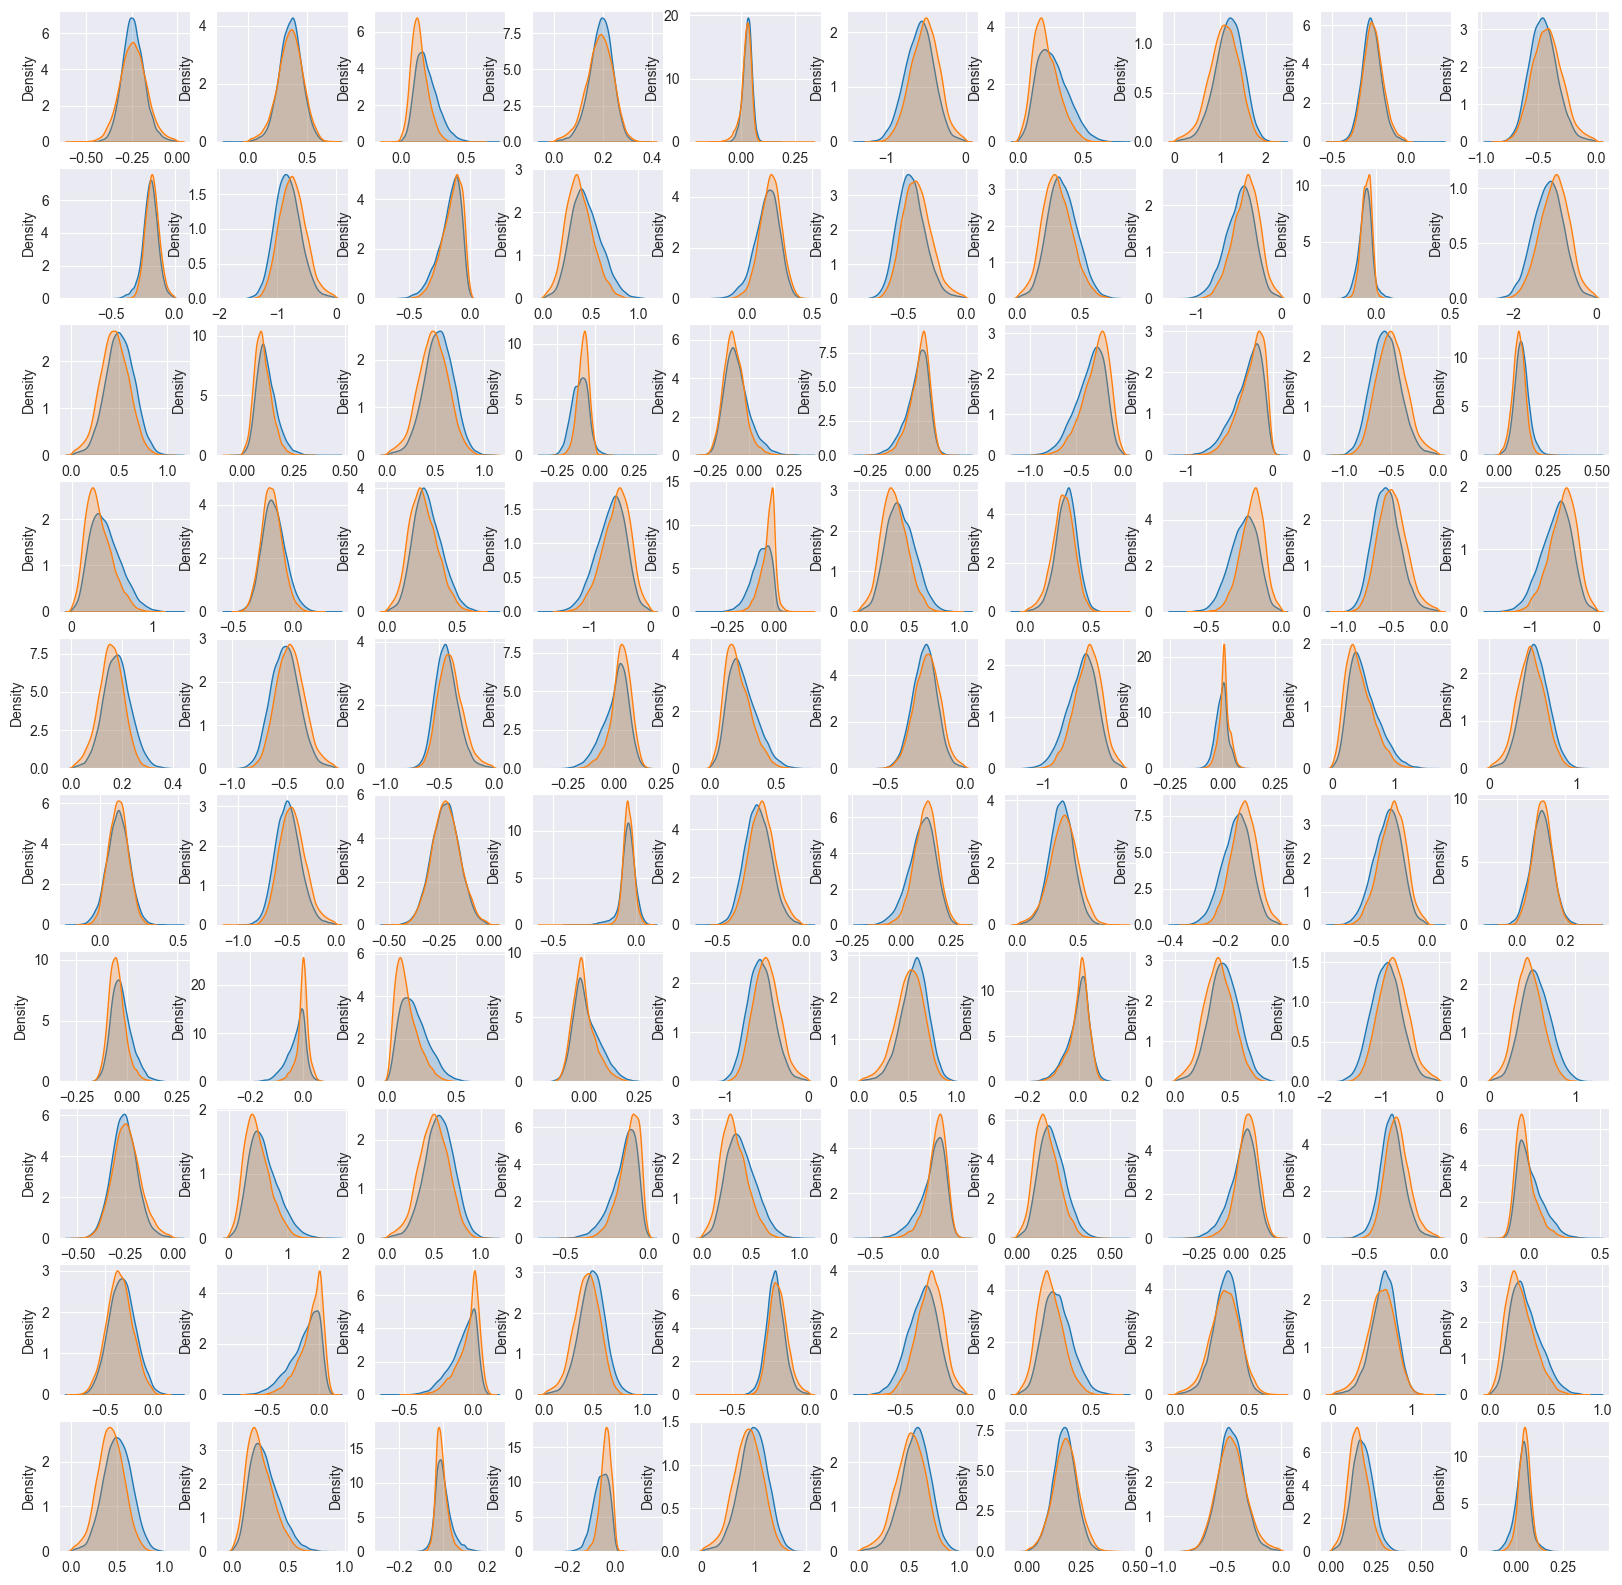

In [13]:
fig, axes = plt.subplots(nrows = 10, ncols = 10, figsize = (20, 20))
for dim in range(100):
    idx = df[df['is_sarcastic'] == 0].index.values
    li = list(map(lambda x: sent_w2v[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim // 10, dim % 10])

    idx = df[df['is_sarcastic'] == 1].index.values
    li = list(map(lambda x: sent_w2v[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim // 10, dim % 10])

In [14]:
embeddings_df = pd.DataFrame(sent_w2v.tolist())

In [15]:
embeddings_df['is_sarcastic'] = df['is_sarcastic']

In [16]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,is_sarcastic
0,-0.228420,0.346146,0.123750,0.166984,0.030114,-0.429328,0.134644,0.962193,-0.217066,-0.369273,...,0.151309,-0.028104,-0.033890,0.763063,0.456626,0.186446,-0.412395,0.124360,0.059966,0
1,-0.242139,0.388322,0.186631,0.197267,0.035821,-0.599502,0.273491,1.212768,-0.270633,-0.470338,...,0.295680,0.019214,-0.071727,1.017891,0.580057,0.163469,-0.467207,0.177042,0.024761,0
2,-0.231105,0.318501,0.248352,0.185986,0.046202,-0.677722,0.342096,1.241602,-0.194663,-0.497405,...,0.386495,0.037539,-0.034968,1.056144,0.638049,0.153444,-0.355222,0.162109,-0.017974,1
3,-0.292105,0.362535,0.202088,0.242592,0.000754,-0.692584,0.306601,1.315118,-0.247455,-0.531313,...,0.367830,0.022044,-0.034055,1.112633,0.616339,0.160915,-0.440346,0.217039,0.010730,1
4,-0.219444,0.352859,0.133521,0.164490,0.027180,-0.493131,0.235205,1.043233,-0.236326,-0.398369,...,0.242194,-0.003881,-0.078733,0.865524,0.476915,0.163517,-0.427358,0.154936,0.033150,0


In [17]:
CORR_THRESHOLD = 0.2
features_w2v = np.arange(100)
correlations =[{'is_sarcastic': embeddings_df[f].corr(embeddings_df['is_sarcastic'])} for f in features_w2v]
train_corr_w2v = pd.DataFrame(correlations, index=features_w2v)

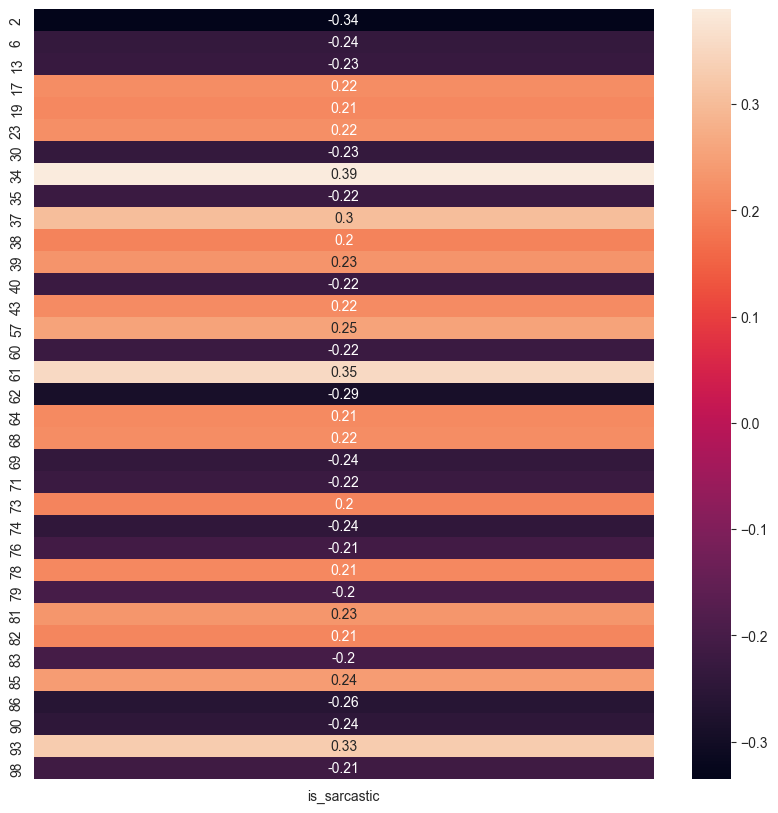

In [18]:
#Top features from word2vec - 36 features
mask = train_corr_w2v.apply(lambda x: abs(x) > CORR_THRESHOLD).to_numpy()
top_features = train_corr_w2v.loc[mask]

plt.figure(figsize = (10, 10))
sns.heatmap(top_features, annot=True)
plt.show()

## GloVe

In [1]:
#run if you need to download the 6B token pretrained GloVe vectors
!wget -P "embeddings" "https://nlp.stanford.edu/data/glove.6B.zip"
!unzip "embeddings/glove.6B.zip" -d "embeddings/"

--2025-04-06 02:50:07--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-06 02:50:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘embeddings/glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.09MB/s    in 2m 41s  

2025-04-06 02:52:50 (5.10 MB/s) - ‘embeddings/glove.6B.zip’ saved [862182613/862182613]

Archive:  embeddings/glove.6B.zip
  inflating: embeddings//glove.6B.50d.txt  
  inflati

In [3]:
df2 = master_df[['headline', 'headline_cleaned', 'tokenized_text_nltk', 'lemmatized_text_nltk', 'is_sarcastic']].copy()
df2.head()

,headline,headline_cleaned,tokenized_text_nltk,lemmatized_text_nltk,is_sarcastic
0,former versace store clerk sues over secret 'b...,former versace store clerk sues over secret bl...,"['former', 'versace', 'store', 'clerk', 'sues'...","['former', 'versace', 'store', 'clerk', 'sue',...",0
1,the 'roseanne' revival catches up to our thorn...,the roseanne revival catches up to our thorny ...,"['the', 'roseanne', 'revival', 'catches', 'up'...","['roseanne', 'revival', 'catch', 'thorny', 'po...",0
2,mom starting to fear son's web series closest ...,mom starting to fear sons web series closest t...,"['mom', 'starting', 'to', 'fear', 'sons', 'web...","['mom', 'starting', 'fear', 'son', 'web', 'ser...",1
3,"boehner just wants wife to listen, not come up...",boehner just wants wife to listen not come up ...,"['boehner', 'just', 'wants', 'wife', 'to', 'li...","['boehner', 'just', 'want', 'wife', 'listen', ...",1
4,j.k. rowling wishes snape happy birthday in th...,jk rowling wishes snape happy birthday in the ...,"['jk', 'rowling', 'wishes', 'snape', 'happy', ...","['jk', 'rowling', 'wish', 'snape', 'happy', 'b...",0


In [4]:
df2['tokenized_text_nltk'] = df2['tokenized_text_nltk'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').replace(",",''))
df2['tokenized_text_nltk'] = df2['tokenized_text_nltk'].apply(lambda x: x.split())
df2['lemmatized_text_nltk'] = df2['lemmatized_text_nltk'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').replace(",",''))
df2['lemmatized_text_nltk'] = df2['lemmatized_text_nltk'].apply(lambda x: x.split())

In [5]:
glove_dict = {}
with open('embeddings/glove.6B.100d.txt') as f:
    for line in f.readlines():
        vec = line.split()
        glove_dict[vec[0]] = np.array(vec[1:], dtype=np.float32)

In [8]:
def get_glove_embeddings(tokens):
    vectors = []
    for token in tokens:
        try:
            vectors.append(glove_dict[token])
        except KeyError:
            vectors.append(np.zeros(100, dtype=np.float32))
    return vectors

In [9]:
df2['tokenized_glove'] = df2['tokenized_text_nltk'].apply(lambda x: get_glove_embeddings(x))
df2['lemmatized_glove'] = df2['lemmatized_text_nltk'].apply(lambda x: get_glove_embeddings(x))

In [18]:
sent_glove = get_sentence_embedding(df2, 'glove')

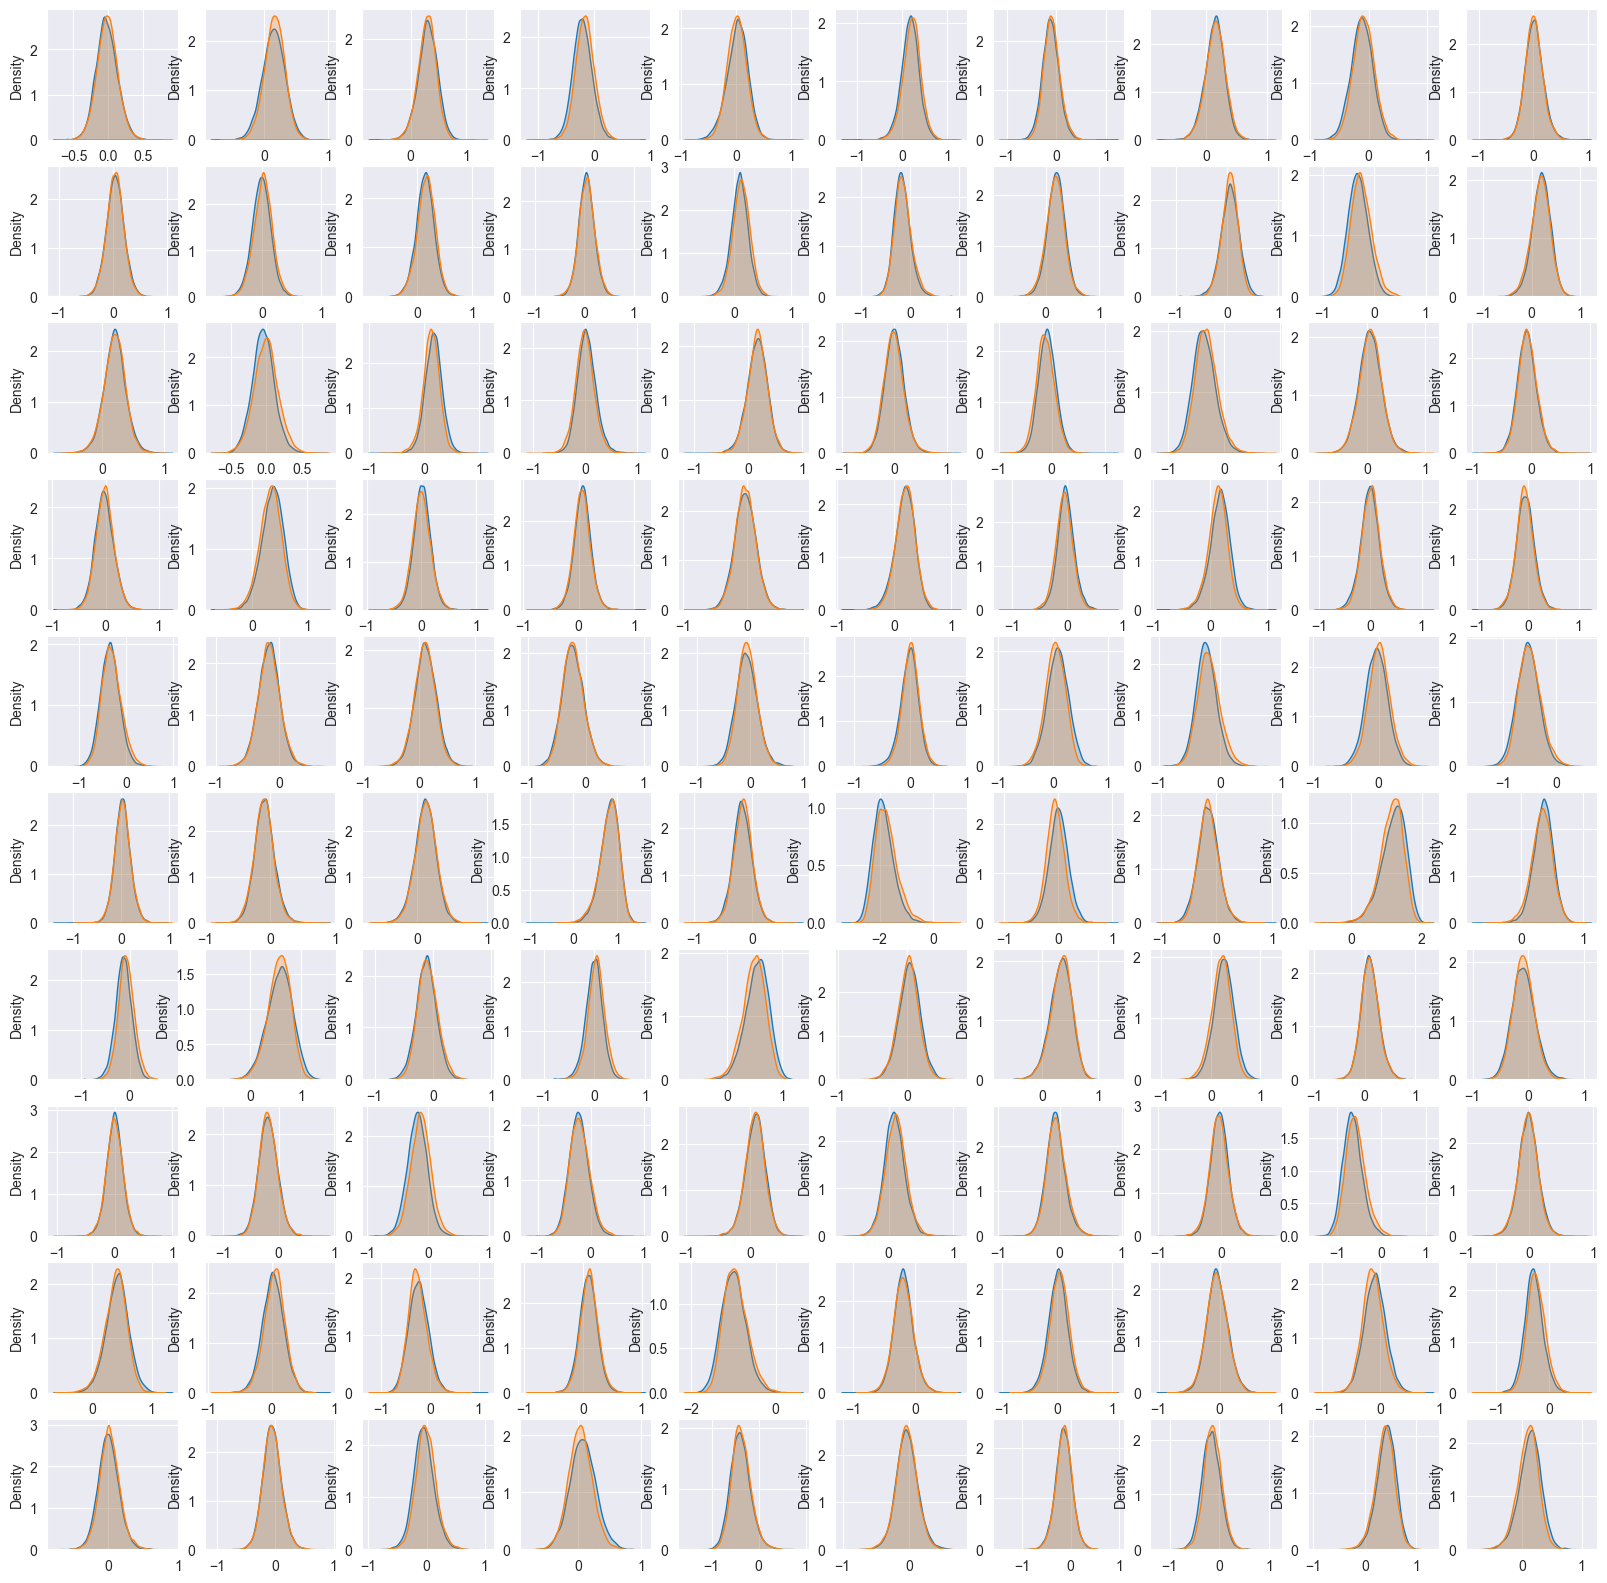

In [19]:
fig, axes = plt.subplots(nrows = 10, ncols = 10, figsize = (20, 20))
for dim in range(100):
    idx = df2[df2['is_sarcastic'] == 0].index.values
    li = list(map(lambda x: sent_glove[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim // 10, dim % 10])

    idx = df2[df2['is_sarcastic'] == 1].index.values
    li = list(map(lambda x: sent_glove[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim // 10, dim % 10])

In [20]:
embeddings_df2 = pd.DataFrame(sent_glove.tolist())
embeddings_df2['is_sarcastic'] = df['is_sarcastic']
embeddings_df2.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,is_sarcastic
0,0.243380,-0.025603,0.216012,-0.357350,0.304848,0.474501,-0.122800,-0.054432,0.007947,0.288998,...,0.064945,0.149139,0.016281,-0.328664,-0.202825,-0.090896,0.127161,0.385822,-0.005062,0
1,-0.154234,0.120977,0.363704,-0.199000,-0.111789,-0.001351,-0.281714,-0.204507,-0.211732,0.025786,...,-0.022769,-0.208721,0.031541,-0.493274,-0.023034,-0.039547,-0.140745,0.496507,0.366890,0
2,0.058536,0.202179,0.264199,-0.324081,-0.104899,0.151055,-0.170223,0.092677,0.017790,-0.029529,...,0.190389,0.279157,-0.139875,-0.645543,-0.036910,-0.088657,-0.321706,0.396789,0.237239,1
3,-0.129464,0.306794,0.364361,-0.239001,0.070814,0.155579,-0.155550,0.012251,0.038076,0.044495,...,-0.214215,-0.081916,-0.149309,-0.548744,-0.120383,-0.205631,-0.188458,0.525969,0.274317,1
4,-0.119868,0.056721,0.292195,-0.086006,-0.170078,0.413380,-0.086037,-0.027807,-0.128584,-0.084582,...,0.089643,0.175420,0.106049,-0.462106,-0.071823,-0.015760,-0.202752,0.069296,0.095170,0


In [36]:
CORR_THRESHOLD = 0.1
features_glove = np.arange(100)
correlations2 =[{'is_sarcastic': embeddings_df2[f].corr(embeddings_df2['is_sarcastic'])} for f in features_glove]
train_corr_glove = pd.DataFrame(correlations2, index=features_glove)

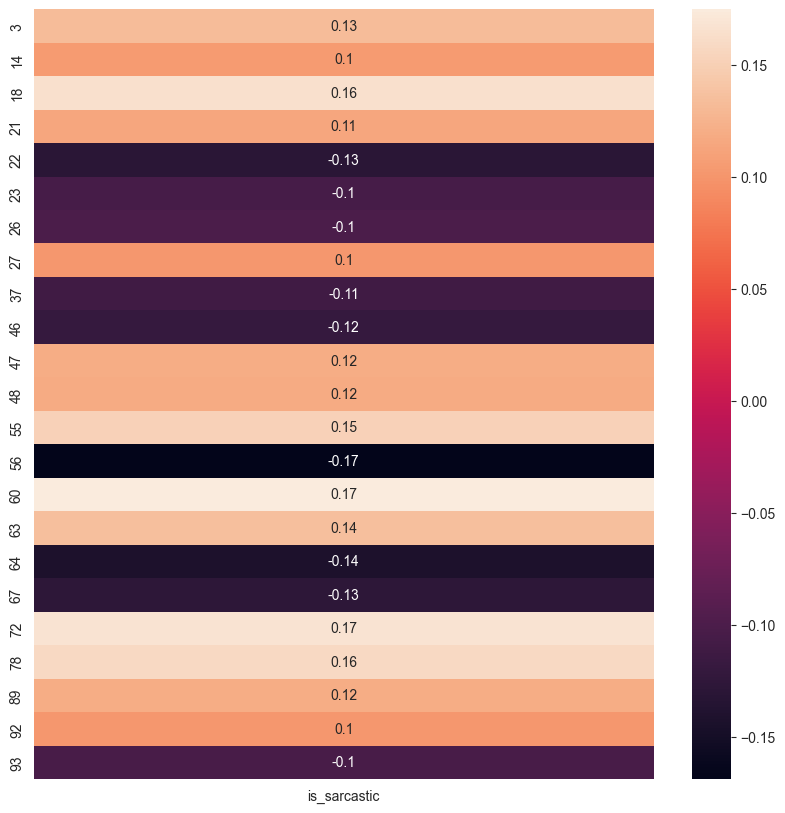

In [37]:
#Top features from GloVe - 23 features (0 features with corr of at least 0.2)
mask2 = train_corr_glove.apply(lambda x: abs(x) > CORR_THRESHOLD).to_numpy()
top_features_glove = train_corr_glove.loc[mask2]

plt.figure(figsize = (10, 10))
sns.heatmap(top_features_glove, annot=True)
plt.show()

## LDA2Vec

In [50]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2dense
import numpy as np

In [51]:
# Create a dictionary
tokenized_dict = Dictionary(tokenized_sentences)
lemmatized_dict = Dictionary(lemmatized_sentences)

In [52]:
# Convert to bag-of-words format
tokenized_corpus = [tokenized_dict.doc2bow(text) for text in tokenized_sentences]
lemmatized_corpus = [lemmatized_dict.doc2bow(text) for text in lemmatized_sentences]

In [ ]:
# Train LDA models
lda_tokenized = LdaModel(tokenized_corpus, num_topics=10, id2word=tokenized_dict)
lda_lemmatized = LdaModel(lemmatized_corpus, num_topics=10, id2word=lemmatized_dict)

In [59]:
# Get topic distributions for each document
tokenized_topics = lda_tokenized.get_document_topics(tokenized_corpus)
lemmatized_topics = lda_lemmatized.get_document_topics(lemmatized_corpus)

In [60]:
df['Tokenized_lda_topics'] = tokenized_topics
df['Lemmatized_lda_topics'] = lemmatized_topics

In [15]:
tokenized_topics[0]

[(0, 0.14148138),
 (1, 0.09167796),
 (4, 0.5092524),
 (6, 0.08440458),
 (8, 0.12791975)]

In [63]:
# Convert topic distributions to dense vectors
def get_dense_topics(topics):
    dense_topics = []
    for topic in topics:
        topic_vector = [0]*10  # Assuming 10 topics
        for topic_id, prob in topic:
            topic_vector[topic_id] = prob
        dense_topics.append(topic_vector)
    return dense_topics

In [64]:
tokenized_dense_topics = get_dense_topics(tokenized_topics)
lemmatized_dense_topics = get_dense_topics(lemmatized_topics)

print(tokenized_dense_topics[0])

# Add dense topic vectors to DataFrame
df['Tokenized_lda_topics'] = tokenized_dense_topics
df['Lemmatized_lda_topics'] = lemmatized_dense_topics


[0, 0, 0, 0.1073307, 0.718177, 0, 0, 0.11625141, 0, 0]


In [69]:
for i, topic in lda_lemmatized.show_topics(num_topics=10, num_words=10, formatted=False):
    print(f"Topic {i}: " + ", ".join([word for word, _ in topic]))

Topic 0: trump, police, attack, nation, stop, not, say, is, call, report
Topic 1: week, man, climate, change, break, be, eye, ad, trump, presidential
Topic 2: i, not, is, do, court, am, supreme, know, trump, gop
Topic 3: new, is, not, find, have, study, year, are, idea, report
Topic 4: story, new, cop, introduces, human, report, turn, is, social, thought
Topic 5: trump, clinton, not, house, white, new, deal, hillary, campaign, bad
Topic 6: man, area, is, not, world, war, woman, love, time, still
Topic 7: is, trump, not, are, donald, be, president, bush, win, next
Topic 8: school, new, is, wa, gay, gun, shooting, obama, city, government
Topic 9: trump, democrat, case, user, crisis, men, someone, summer, is, test


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for i in range(10):
    words = dict(lda_tokenized.show_topic(i, topn=20))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {i}")
    plt.show()


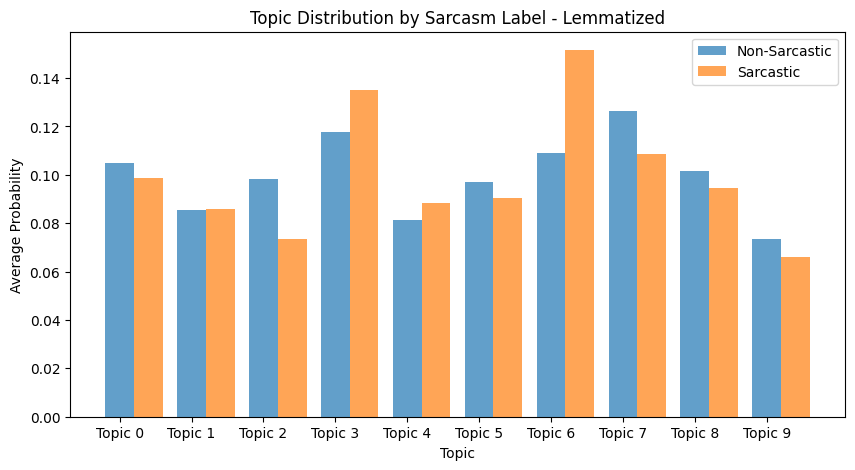

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Separate the topic vectors based on sarcasm label
sarcastic_topics = np.array(df[df['is_sarcastic'] == 1]['Lemmatized_lda_topics'].tolist())
non_sarcastic_topics = np.array(df[df['is_sarcastic'] == 0]['Lemmatized_lda_topics'].tolist())

# Compute the average topic distribution
avg_sarcastic = np.mean(sarcastic_topics, axis=0)
avg_non_sarcastic = np.mean(non_sarcastic_topics, axis=0)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
topics = range(10)  # Assuming 10 topics
width = 0.4  # Bar width

ax.bar(topics, avg_non_sarcastic, width=width, label="Non-Sarcastic", alpha=0.7)
ax.bar(np.array(topics) + width, avg_sarcastic, width=width, label="Sarcastic", alpha=0.7)

ax.set_xlabel("Topic")
ax.set_ylabel("Average Probability")
ax.set_title("Topic Distribution by Sarcasm Label - Lemmatized")
ax.legend()
plt.xticks(topics, [f"Topic {i}" for i in topics])  # Label topics
plt.show()


KDE Plot of topic distributions for sarcastic and non-sarcastic headlines

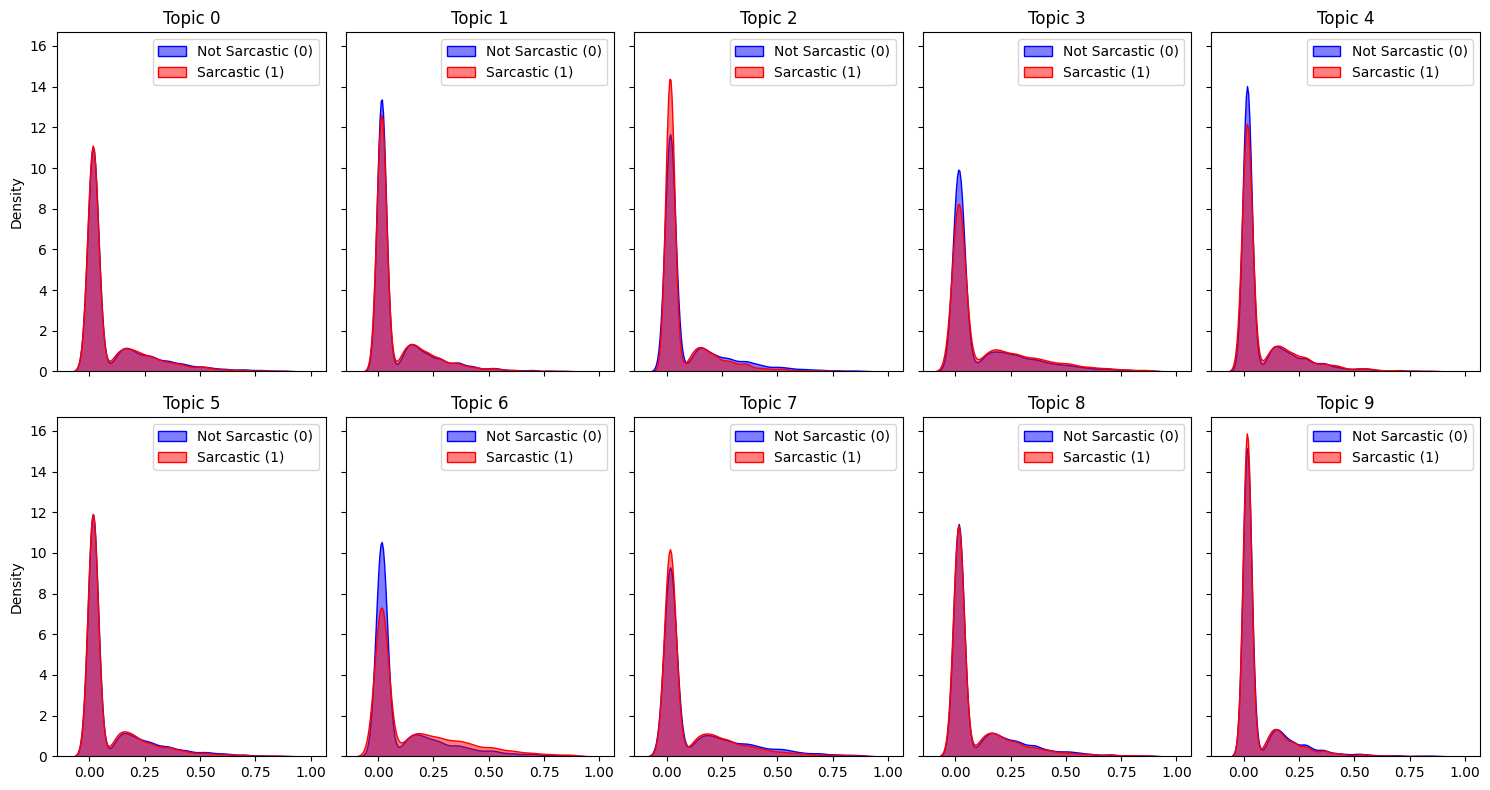

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert 'Lemmatized_lda_topics' column into a DataFrame
topics_array = np.array(df["Lemmatized_lda_topics"].tolist())  # Convert list of lists to NumPy array
num_topics = topics_array.shape[1]  # Number of topics

# Separate topics based on sarcasm label
sarcastic_topics = topics_array[df["is_sarcastic"] == 1]
non_sarcastic_topics = topics_array[df["is_sarcastic"] == 0]

# Plot KDE for each topic
fig, axes = plt.subplots(2, 5, figsize=(15, 8), sharex=True, sharey=True)  # Adjust grid for num_topics
axes = axes.flatten()

for i in range(num_topics):
    sns.kdeplot(non_sarcastic_topics[:, i], ax=axes[i], label="Not Sarcastic (0)", color="blue", fill=True, alpha=0.5)
    sns.kdeplot(sarcastic_topics[:, i], ax=axes[i], label="Sarcastic (1)", color="red", fill=True, alpha=0.5)
    axes[i].set_title(f"Topic {i}")
    axes[i].legend()

plt.tight_layout()
plt.show()


Note: The topics consisted of mostly stopwords when attempting to use the non-lemmatized version

In [89]:
df.to_csv('data/embeddings_nltk.csv', index=False)

Please avoid pushing this csv file to github. The files are large and will take 5-6 minutes to store as a csv locally

## CountVectorizer and TfidfVectorizer

Owen

In [28]:
# Cell 1: Import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [20]:
# Cell 2: Convert lists of tokens back to strings for vectorizers
tokenized_texts = [' '.join(tokens) for tokens in tokenized_sentences]
lemmatized_texts = [' '.join(tokens) for tokens in lemmatized_sentences]

In [22]:
# Cell 3: Implement CountVectorizer
# Create and fit CountVectorizer (max_features=1000 to avoid overly sparse matrices)
count_vec_tokenized = CountVectorizer(max_features=1000)
count_vec_lemmatized = CountVectorizer(max_features=1000)


# Transform text data into count vectors
count_tokenized = count_vec_tokenized.fit_transform(tokenized_texts)
count_lemmatized = count_vec_lemmatized.fit_transform(lemmatized_texts)

# Get feature names
tokenized_count_features = count_vec_tokenized.get_feature_names_out()
lemmatized_count_features = count_vec_lemmatized.get_feature_names_out()

print(f"CountVectorizer features shape (tokenized): {count_tokenized.shape}")
print(f"CountVectorizer features shape (lemmatized): {count_lemmatized.shape}")


CountVectorizer features shape (tokenized): (26709, 1000)
CountVectorizer features shape (lemmatized): (26709, 1000)


In [23]:

# Cell 4: Implement TfidfVectorizer
# Create and fit TfidfVectorizer (max_features=1000 to avoid overly sparse matrices)
tfidf_vec_tokenized = TfidfVectorizer(max_features=1000)
tfidf_vec_lemmatized = TfidfVectorizer(max_features=1000)

# Transform text data into TF-IDF vectors
tfidf_tokenized = tfidf_vec_tokenized.fit_transform(tokenized_texts)
tfidf_lemmatized = tfidf_vec_lemmatized.fit_transform(lemmatized_texts)

# Get feature names
tokenized_tfidf_features = tfidf_vec_tokenized.get_feature_names_out()
lemmatized_tfidf_features = tfidf_vec_lemmatized.get_feature_names_out()

print(f"TfidfVectorizer features shape (tokenized): {tfidf_tokenized.shape}")
print(f"TfidfVectorizer features shape (lemmatized): {tfidf_lemmatized.shape}")


TfidfVectorizer features shape (tokenized): (26709, 1000)
TfidfVectorizer features shape (lemmatized): (26709, 1000)


In [24]:

# Cell 5: Create function to extract top features
# Function to extract top features from each document
def get_top_features(matrix, feature_names, top_n=10):
    top_features_per_doc = []
    
    for i in range(matrix.shape[0]):
        # Get feature values for document i
        doc_features = matrix[i].toarray().flatten()
        # Get indices of top features (by value)
        top_indices = doc_features.argsort()[-top_n:][::-1]
        # Get feature names and their values
        top_features = [(feature_names[idx], doc_features[idx]) for idx in top_indices]
        top_features_per_doc.append(top_features)
    
    return top_features_per_doc

In [25]:

# Cell 6: Get top features and add to dataframe
# Get top 5 features for each document
tokenized_count_top = get_top_features(count_tokenized, tokenized_count_features, 5)
lemmatized_count_top = get_top_features(count_lemmatized, lemmatized_count_features, 5)
tokenized_tfidf_top = get_top_features(tfidf_tokenized, tokenized_tfidf_features, 5)
lemmatized_tfidf_top = get_top_features(tfidf_lemmatized, lemmatized_tfidf_features, 5)

# Add to dataframe
df['tokenized_count_top'] = tokenized_count_top
df['lemmatized_count_top'] = lemmatized_count_top
df['tokenized_tfidf_top'] = tokenized_tfidf_top
df['lemmatized_tfidf_top'] = lemmatized_tfidf_top

In [26]:
# Cell 7: Add dense feature vectors to dataframe
# Convert sparse matrices to dense arrays for selected features
# We'll take the first 100 features to avoid making the dataframe too large
tokenized_count_dense = count_tokenized[:, :100].toarray()
lemmatized_count_dense = count_lemmatized[:, :100].toarray()
tokenized_tfidf_dense = tfidf_tokenized[:, :100].toarray()
lemmatized_tfidf_dense = tfidf_lemmatized[:, :100].toarray()

# Add count vector features to dataframe
df['tokenized_count_features'] = tokenized_count_dense.tolist()
df['lemmatized_count_features'] = lemmatized_count_dense.tolist()
df['tokenized_tfidf_features'] = tokenized_tfidf_dense.tolist()
df['lemmatized_tfidf_features'] = lemmatized_tfidf_dense.tolist()


In [27]:
# Cell 8: Display examples of top TFIDF features
# Display example of top TFIDF features for the first few headlines
for i in range(5):
    print(f"Headline: {df['headline'].iloc[i]}")
    print(f"Top TFIDF features (tokenized): {df['tokenized_tfidf_top'].iloc[i]}")
    print("\n")


Headline: former versace store clerk sues over secret 'black code' for minority shoppers
Top TFIDF features (tokenized): [('store', 0.5083117545808206), ('secret', 0.4641108821678654), ('former', 0.4520097563458886), ('black', 0.3928886613364516), ('over', 0.34817736616156264)]


Headline: the 'roseanne' revival catches up to our thorny political mood, for better and worse
Top TFIDF features (tokenized): [('worse', 0.4915417386795098), ('political', 0.43993415731592855), ('better', 0.41459558156287946), ('our', 0.3925549641699866), ('up', 0.29638310190796713)]


Headline: mom starting to fear son's web series closest thing she will have to grandchild
Top TFIDF features (tokenized): [('starting', 0.4073715548705109), ('fear', 0.4061818705229094), ('series', 0.3899743530784772), ('thing', 0.344629484832939), ('mom', 0.32718931745424296)]


Headline: boehner just wants wife to listen, not come up with alternative debt-reduction ideas
Top TFIDF features (tokenized): [('ideas', 0.4591788451

In [29]:
# Cell 9: Save the updated dataframe
# Replace your existing save cell with this
df.to_csv('data/embeddings_count_tfidf.csv', index=False) 